# Implementation of UTwo-stream WAE for SVHN <−−> MNIST transfer


In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline
from skimage import color, transform

from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

from torchvision import datasets

from IPython.display import clear_output

## Parameters

In [2]:
batch_size = 32

folder_mnist = "/ext/czh/two_stream_WAE/datasets/mnist"
folder_svhn = "/ext/czh/two_stream_WAE/datasets/svhn"
download_svhn = True # mnist is automatically downloaded if not in the folder

colormap = np.array(plt.rcParams['axes.prop_cycle'].by_key()['color'])

## Create the datasets

In [3]:
def normalize(x, max_value):
    """ If x takes its values between 0 and max_value, normalize it between -1 and 1"""
    return (x / float(max_value)) * 2 - 1

### SVHN

We follow the methodology of [1] and use the "extra" SVHN set as the training set. The test set can be useful for evaluations beyond the paper.

Concerning the transformation, we turn the 32x32 RGB images and normalize them between -1 and 1

In [4]:
svhn_train = datasets.SVHN(root=folder_svhn, download=download_svhn, split="extra")
svhn_test = datasets.SVHN(root=folder_svhn, download=download_svhn, split="test")

Using downloaded and verified file: /ext/czh/UNIT-mnist-svhn-master/datasets/svhn/extra_32x32.mat
Using downloaded and verified file: /ext/czh/UNIT-mnist-svhn-master/datasets/svhn/test_32x32.mat


In [5]:
def transform_svhn(X):
    X = np.transpose(X, (0,2,3,1))
    X = np.array([color.rgb2gray(im) for im in X])
    X = normalize(X, 1)
    X = X.reshape(len(X), 32, 32, 1)
    
    return X

In [6]:
print("Transforming SVHN train...")
X_svhn_train = transform_svhn(svhn_train.data)

print("Transforming SVHN test...")
X_svhn_test = transform_svhn(svhn_test.data)

Transforming SVHN train...
Transforming SVHN test...


In [7]:
lb_svhn = LabelBinarizer()

Y_svhn_train = lb_svhn.fit_transform(svhn_train.labels.flatten() % 10)
Y_svhn_test = lb_svhn.fit_transform(svhn_test.labels.flatten() % 10)

### MNIST

Translate 28x28 grayscale images to 32x32 RGB images

In [8]:
mnist = input_data.read_data_sets(folder_mnist, one_hot=False)

Extracting /ext/czh/UNIT-mnist-svhn-master/datasets/mnist/train-images-idx3-ubyte.gz
Extracting /ext/czh/UNIT-mnist-svhn-master/datasets/mnist/train-labels-idx1-ubyte.gz
Extracting /ext/czh/UNIT-mnist-svhn-master/datasets/mnist/t10k-images-idx3-ubyte.gz
Extracting /ext/czh/UNIT-mnist-svhn-master/datasets/mnist/t10k-labels-idx1-ubyte.gz


In [9]:
def transform_mnist(X):
    X = X.reshape(len(X), 28, 28)
    X = np.array([transform.resize(im, [32,32]) for im in X])
    X = normalize(X, 1)
    X = X.reshape(len(X), 32, 32, 1)
    
    return X

In [10]:
print("Transforming MNIST train...")
X_mnist_train = transform_mnist(mnist.train.images)

print("Transforming MNIST test...")
X_mnist_test = transform_mnist(mnist.test.images)

Transforming MNIST train...


/home/czh/software/conda/lib/python2.7/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Transforming MNIST test...


In [11]:
lb_mnist = LabelBinarizer()

Y_mnist_train = lb_mnist.fit_transform(mnist.train.labels)
Y_mnist_test = lb_mnist.fit_transform(mnist.test.labels)

### Source and target

In [12]:
X_source = X_svhn_train
Y_source = Y_svhn_train

X_target = X_mnist_train
X_target_test = X_mnist_test
Y_target_test = Y_mnist_test

## Create the model

### Useful functions

In [13]:
def leaky_relu(x):
    alpha = 0.05
    return tf.maximum(x, alpha * x)

Code for instance normalization [1] adapted from [here](https://github.com/rickbarraza/tensorflow-cyclegan/blob/master/cyclegan.py)

In [14]:
def instance_normalization(x, name):
    with tf.variable_scope("instance_norm"):
        with tf.variable_scope(name):
            epsilon = 1e-5
            mean, var = tf.nn.moments(x, [1, 2], keep_dims=True)
            scale = tf.get_variable('scale',[x.get_shape()[-1]], 
                                    initializer=tf.truncated_normal_initializer(mean=1.0, stddev=0.02))
            offset = tf.get_variable('offset',[x.get_shape()[-1]],initializer=tf.constant_initializer(0.0))
            out = scale*tf.div(x-mean, tf.sqrt(var+epsilon)) + offset

            return out

### Placeholders

In [15]:
ipt_source = tf.placeholder(tf.float32, shape=[None, 32, 32, 1], name='ipt_source')
ipt_target = tf.placeholder(tf.float32, shape=[None, 32, 32, 1], name='ipt_target')
labels_source = tf.placeholder(tf.int32, shape=[None, 10], name="labels_source")

### Discriminator Network

The discriminator has two roles: separating real from generated samples, and classifying the MNIST digits.

The first layer's weights depend on the task (source to target or target to source), while all the other layers have shared weights. Indeed, "this allows us to adapt a classifier trained in the source domain to the target
domain." [1]

In [16]:
def discriminator(x, scope,reuses1,reuses2):
    """Discriminator for the two GANs, and source classifier
    
    Parameters
    ----------
    x : tensor of shape = [?, 32, 32, 1]
        Either the input (real sample) or the generated image (fake sample)
    scope : {'source', 'target'}
        Choose 'source' for separating real_source from fake_source and 'target' for separating real_target from
        fake_target. Only used for the first layer.

    Returns
    -------
    fc1_sigmoid : tensor of shape = [1]
        Output of the discriminator real vs fake with a sigmoid
    fc1_logits : tensor of shape = [1]
        Output of the discriminator real vs fake without any activation function
    fc1_classif : tensor of shape = [10]
        Output of the source classifier, without any activation (softmax used after in the loss)
        
    """
    
    initializer = tf.contrib.layers.xavier_initializer()

    with tf.variable_scope(scope + "/discriminator", reuse=reuses1):
        # Layer 1: 32x32x1 --> 16x16x64 (n=1 or 3)
        conv1 = tf.layers.conv2d(x, 64, [5,5], strides=2, padding='SAME', kernel_initializer=initializer, activation=leaky_relu)
        conv1 = instance_normalization(conv1, "conv1")
        
    with tf.variable_scope("discriminator", reuse=reuses2):
        # Layer 2: 16x16x64 --> 8x8x128        
        conv2 = tf.layers.conv2d(conv1, 128, [5,5], strides=2, padding='SAME', kernel_initializer=initializer, activation=leaky_relu)
        conv2 = instance_normalization(conv2, "conv2")
        
        # Layer 3: 8x8x128 --> 4x4x256    
        conv3 = tf.layers.conv2d(conv2, 256, [5,5], strides=2, padding='SAME', kernel_initializer=initializer, activation=leaky_relu)
        conv3 = instance_normalization(conv3, "conv3")
        
        # Layer 4: 4x4x256 --> 2x2x512    
        conv4 = tf.layers.conv2d(conv3, 512, [5,5], strides=2, padding='SAME', kernel_initializer=initializer, activation=leaky_relu)
        conv4 = instance_normalization(conv4, "conv4")

        # Layer 3: 2x2x512 --> 1
        fc1 = tf.contrib.layers.flatten(conv4)
        fc1_logits = tf.layers.dense(inputs=fc1, units=1, activation=None, kernel_initializer=initializer)
        fc1_sigmoid = tf.sigmoid(fc1_logits)
        fc1_classif = tf.layers.dense(inputs=fc1, units=10, activation=None, kernel_initializer=initializer)
        
    return fc1_sigmoid, fc1_logits, fc1_classif

### Encoder Network

Transform either source or target samples to the embedding space. Since the encoder is part of a VAE, the embedding space corresponds to a gaussian with mean $\mu(x)$ and variance $\sigma^2(x)$. The encoder outputs $\mu$ and $log(\sigma^2)$, but returns also a random tensor sampled from this gaussian.

In [17]:
def encoder(x, scope,reuses):
    """Encoder for the two GANs
    
    Parameters
    ----------
    x : tensor of shape = [?, 32, 32, 1]
        Normally takes a real image (except if you use cycle-consistency)
    scope : {'source', 'target'}
        Corresponds to the domain of x

    Returns
    -------
    mu : tensor of shape = [?, 8, 8, 1024]
        Mean of the embedding space conditionned on x
    log_sigma_sq : tensor of shape = [?, 8, 8, 1024]
        log of the variance of the embedding space conditionned on x
    z : tensor of shape = [?, 8, 8, 1024]
        Random sample generated from mu(x) and sigma(x)
        
    """
    
    initializer = tf.contrib.layers.xavier_initializer()
    
    with tf.variable_scope(scope + "/encoder", reuse=None): # not shared
        # Layer 1: 32x32x1 --> 16x16x64
        conv1 = tf.layers.conv2d(x, 64, [5, 5], strides=2, padding='SAME', 
                                 kernel_initializer=initializer, activation=leaky_relu)
        conv1 = instance_normalization(conv1, "conv1")
    
    with tf.variable_scope("encoder", reuse=reuses): # shared weights
        # Layer 2: 16x16x64 --> 8x8x128
        conv2 = tf.layers.conv2d(conv1, 128, [5, 5], strides=2, padding='SAME', 
                                 kernel_initializer=initializer, activation=leaky_relu)
        conv2 = instance_normalization(conv2, "conv2")
        
        # Layer 3: 8x8x128 --> 8x8x256
        conv3 = tf.layers.conv2d(conv2, 256, [8, 8], strides=1, padding='SAME', 
                                 kernel_initializer=initializer, activation=leaky_relu)
        conv3 = instance_normalization(conv3, "conv3")
        
        # Layer 4: 8x8x256 --> 8x8x512
        conv4 = tf.layers.conv2d(conv3, 512, [1, 1], strides=1, padding='SAME', 
                                 kernel_initializer=initializer, activation=leaky_relu)
        conv4 = instance_normalization(conv4, "conv4")

        # Layer 5 : 8x8x512 --> 8x8x1024
        mu = tf.layers.conv2d(conv4, 1024, [1, 1], strides=1, padding='SAME', 
                              kernel_initializer=initializer, activation=None)
        log_sigma_sq = tf.layers.conv2d(conv4, 1024, [1, 1], strides=1, padding='SAME', 
                              kernel_initializer=initializer, activation=None)
        
        z = mu + tf.multiply(tf.exp(log_sigma_sq / 2), tf.random_normal([tf.shape(x)[0],8,8,1024],0,1,dtype=tf.float32)) # latent space
        
    return mu, log_sigma_sq, z

### Generator Network

Transform the embedding space to the source or target domain

In [18]:
def generator(z, scope,reuses1,reuses2):
    """Generator for the two GANs
    
    Parameters
    ----------
    x : tensor of shape = [?, 8, 8, 1024]
        Normally takes an encoded image (point in the embedding space)
    scope : {'source', 'target'}
        Corresponds to the domain of x

    Returns
    -------
    deconv5 : tensor of shape = [?, 32, 32, 1]
        Generated image
    """
    initializer = tf.contrib.layers.xavier_initializer()
    
    with tf.variable_scope("generator", reuse=reuses1): # shared weights
        # Layer 1: 8x8x1024 --> 16x16x512
        deconv1 = tf.layers.conv2d_transpose(z, 512, [4, 4], strides=2, padding='SAME', kernel_initializer=initializer, activation=leaky_relu)
        deconv1 = instance_normalization(deconv1, "deconv1")
        
        # Layer 2: 16x16x512 --> 32x32x256
        deconv2 = tf.layers.conv2d_transpose(deconv1, 256, [4, 4], strides=2, padding='SAME', kernel_initializer=initializer, activation=leaky_relu)
        deconv2 = instance_normalization(deconv2, "deconv2")
        
        # Layer 3: 32x32x256 --> 32x32x128
        deconv3 = tf.layers.conv2d_transpose(deconv2, 128, [4, 4], strides=1, padding='SAME', kernel_initializer=initializer, activation=leaky_relu)
        deconv3 = instance_normalization(deconv3, "deconv3")
        
    with tf.variable_scope(scope + "/generator", reuse=reuses2):
        # Layer 3: 32x32x128 --> 32x32x64
        deconv4 = tf.layers.conv2d_transpose(deconv3, 64, [4, 4], strides=1, padding='SAME', kernel_initializer=initializer, activation=leaky_relu)
        deconv4 = instance_normalization(deconv4, "deconv4")

        # Layer 6: 32x32x64 --> 32x32x1
        deconv5 = tf.layers.conv2d_transpose(deconv4, 1, [1, 1], strides=1, padding='SAME', kernel_initializer=initializer, activation=tf.nn.tanh)
        
    return deconv5

### Define the graph

In [19]:
def log(tensor):
    return tf.log(tensor + 1e-7)

#### Encoders

In [20]:
E_mean_source, E_log_sigma_sq_source, E_source = encoder(ipt_source, "source",None)
E_mean_target, E_log_sigma_sq_target, E_target = encoder(ipt_target, "target",True)

#### Generators

In [21]:
# GAN
G_t2s = generator(E_target, "source",None,None) # target to source (t2s)
G_s2t = generator(E_source, "target",True,None) # source to target (s2t)

# VAE
G_t2t = generator(E_target, "target",True,True) # target to target (t2t)
G_s2s = generator(E_source, "source",True,True) # source to source (s2s)

#### Discriminators

In [22]:
D_target, D_target_logits, D_target_classif = discriminator(ipt_target, "target",None,None)
D_source, D_source_logits, D_source_classif = discriminator(ipt_source, "source",None,True)

DG_t2s, DG_t2s_logits, DG_t2s_classif = discriminator(G_t2s, "source",True,True)
DG_s2t, DG_s2t_logits, DG_s2t_classif = discriminator(G_s2t, "target",True,True)

### Losses

#### VAE losses

Source : [Variational Autoencoder: Intuition and Implementation](https://wiseodd.github.io/techblog/2016/12/10/variational-autoencoder/)

In [23]:
lambda_rec = 1
lambda_kl = 1

In [24]:
def normalize(x):
    return (x + 1) / 2

In [25]:
def reconstruction_loss(x, x_rec):
    x, x_rec = normalize(x), normalize(x_rec)
    return - tf.reduce_mean(x * log(x_rec) + (1 - x) * log(1 - x_rec))

In [26]:
def latent_loss(mean, log_std_sq):
    return 0.5 * tf.reduce_mean(tf.square(mean) + tf.exp(log_std_sq) - log_std_sq - 1.)

In [27]:
vae_s2s_loss = lambda_rec * reconstruction_loss(ipt_source, G_s2s) \
               + lambda_kl * latent_loss(E_mean_source, E_log_sigma_sq_source)
vae_t2t_loss = lambda_rec * reconstruction_loss(ipt_target, G_t2t) \
               + lambda_kl * latent_loss(E_mean_target, E_log_sigma_sq_target)

#### Classification loss

In [28]:
lambda_classif = 1

In [29]:
classif_source_loss = lambda_classif * tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=labels_source, 
                                                                                              logits=D_source_classif))

#### GAN losses

See [3]

In [30]:
def wasserstein_disc_loss(D_real, D_gen):
    """ Warning : take logits as input"""
    return tf.reduce_mean(D_gen) - tf.reduce_mean(D_real)

def wasserstein_gen_loss(D_gen):
    """ Warning : take logits as input"""
    return -tf.reduce_mean(D_gen)

In [31]:
D_s2t_loss = wasserstein_disc_loss(D_target_logits, DG_s2t_logits)
G_s2t_loss = wasserstein_gen_loss(DG_s2t_logits)

In [32]:
D_t2s_loss = wasserstein_disc_loss(D_source_logits, DG_t2s_logits)
G_t2s_loss = wasserstein_gen_loss(DG_t2s_logits)

### Solvers

In [33]:
model_vars = tf.trainable_variables()

D_s2t_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='target/discriminator') \
             + tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='discriminator')

D_t2s_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='source/discriminator') \
             + tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='discriminator')

G_s2t_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='source/encoder') \
             + tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='target/generator') \
             + tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='generator') \
             + tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='encoder')
G_t2s_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='target/encoder') \
             + tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='source/generator') \
             + tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='generator') \
             + tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='encoder')
            

vae_s2s_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='source/encoder') \
               + tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='source/generator') \
               + tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='generator') \
               + tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='encoder')
vae_t2t_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='target/encoder') \
               + tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='target/generator') \
               + tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='generator') \
               + tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='encoder')

In [34]:
with tf.variable_scope("optim", reuse=None):
    D_s2t_solver = tf.train.RMSPropOptimizer(learning_rate=5e-5).minimize(D_s2t_loss, var_list=D_s2t_vars)
    G_s2t_solver = tf.train.RMSPropOptimizer(learning_rate=5e-5).minimize(G_s2t_loss, var_list=G_s2t_vars)
    D_t2s_solver = tf.train.RMSPropOptimizer(learning_rate=5e-5).minimize(D_t2s_loss, var_list=D_t2s_vars)
    G_t2s_solver = tf.train.RMSPropOptimizer(learning_rate=5e-5).minimize(G_t2s_loss, var_list=G_t2s_vars)

    classif_source_solver = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(classif_source_loss, 
                                                                                var_list=D_t2s_vars)

    vae_s2s_solver = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(vae_s2s_loss, var_list=vae_s2s_vars)
    vae_t2t_solver = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(vae_t2t_loss, var_list=vae_t2t_vars)

Clipping for Wasserstein loss [3]

In [35]:
clip_D_s2t = [p.assign(tf.clip_by_value(p, -0.1, 0.1)) for p in D_s2t_vars]
clip_D_t2s = [p.assign(tf.clip_by_value(p, -0.1, 0.1)) for p in D_t2s_vars]

## Run the model

In [38]:
# sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=False))
gpu_options=tf.GPUOptions(allow_growth=True)
sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))

In [39]:
sess.run(tf.global_variables_initializer())
D_s2t_loss_list = []
G_s2t_loss_list = []
D_t2s_loss_list = []
G_t2s_loss_list = []
vae_s2s_loss_list = []
vae_t2t_loss_list = []
classif_t2s_loss_list = []
accuracy_list = []
iter_list = []
i = 0

In [40]:
saver = tf.train.Saver()
saver.restore(sess, "model/model.ckpt")

INFO:tensorflow:Restoring parameters from model/model.ckpt


In [39]:
# D_s2t_loss_list = list(np.loadtxt("D_s2t_loss_list.txt"))
# G_s2t_loss_list = list(np.loadtxt("G_s2t_loss_list.txt"))
# D_t2s_loss_list = list(np.loadtxt("D_t2s_loss_list.txt"))
# G_t2s_loss_list = list(np.loadtxt("G_t2s_loss_list.txt"))
# vae_s2s_loss_list = list(np.loadtxt("vae_s2s_loss_list.txt"))
# vae_t2t_loss_list = list(np.loadtxt("vae_t2t_loss_list.txt"))
# iter_list = list(np.loadtxt("iter_list.txt"))
# i = len(iter_list)

In [40]:
nb_iter = 500
nb_iter_d = 5
nb_iter_vae = 1
nb_iter_g = 1
nb_iter_classif = 2
verbose = True

i_init = i
for i in range(i, nb_iter+i):
    for k in range(nb_iter_vae):
        sample_source = X_source[np.random.choice(len(X_source), batch_size)]
        sample_target = X_target[np.random.choice(len(X_target), batch_size)]
        
        ## Optimizing VAE s2s
        _, vae_s2s_loss_curr = sess.run([vae_s2s_solver, vae_s2s_loss], feed_dict={ipt_source: sample_source})
        _, vae_t2t_loss_curr = sess.run([vae_t2t_solver, vae_t2t_loss], feed_dict={ipt_target: sample_target})
        
    for k in range(nb_iter_g):
        sample_source = X_source[np.random.choice(len(X_source), batch_size)]
        sample_target = X_target[np.random.choice(len(X_target), batch_size)]
        
        # Optimizing gen s2t
        _, G_s2t_loss_curr = sess.run([G_s2t_solver, G_s2t_loss], feed_dict={ipt_source: sample_source, 
                                                                             ipt_target: sample_target})
    
        ## Optimizing gen t2s
        _, G_t2s_loss_curr = sess.run([G_t2s_solver, G_t2s_loss], feed_dict={ipt_source: sample_source, 
                                                                             ipt_target: sample_target})
        
    for k in range(nb_iter_d):
        sample_source = X_source[np.random.choice(len(X_source), batch_size)]
        sample_target = X_target[np.random.choice(len(X_target), batch_size)]
        
        # Optimizing s2t
        _, D_s2t_loss_curr,_ = sess.run([D_s2t_solver, D_s2t_loss, clip_D_s2t], feed_dict={ipt_source: sample_source, 
                                                                                           ipt_target: sample_target})
    
        ## Optimizing t2s
        _, D_t2s_loss_curr,_ = sess.run([D_t2s_solver, D_t2s_loss, clip_D_t2s], feed_dict={ipt_source: sample_source, 
                                                                                           ipt_target: sample_target})
        
        
    for k in range(nb_iter_classif):
        idx_sample_source = np.random.choice(len(X_source), batch_size)
        sample_source = X_source[idx_sample_source]
        sample_source_labels = Y_source[idx_sample_source]
        sample_target = X_target[np.random.choice(len(X_target), batch_size)]
        
        _, classif_t2s_loss_curr = sess.run([classif_source_solver, classif_source_loss], feed_dict={ipt_source: sample_source, 
                                                                                                     labels_source: sample_source_labels})
        
    iter_list.append(i)
    D_s2t_loss_list.append(D_s2t_loss_curr)
    G_s2t_loss_list.append(G_s2t_loss_curr)
    D_t2s_loss_list.append(D_t2s_loss_curr)
    G_t2s_loss_list.append(G_t2s_loss_curr)
    vae_s2s_loss_list.append(vae_s2s_loss_curr)
    vae_t2t_loss_list.append(vae_t2t_loss_curr)
    classif_t2s_loss_list.append(classif_t2s_loss_curr)
    
    if verbose:
        clear_output(wait=True)
        print('Iter: {} / {}'.format(i, i_init + nb_iter - 1))
        print('D loss s2t: {:.4}'.format(D_s2t_loss_curr))
        print('D loss t2s: {:.4}'.format(D_t2s_loss_curr))
        print('G loss s2t: {:.4}'.format(G_s2t_loss_curr))
        print('G loss t2s: {:.4}'.format(G_t2s_loss_curr))
        print('VAE loss s2s: {:.4}'.format(vae_s2s_loss_curr))
        print('VAE loss t2t: {:.4}'.format(vae_t2t_loss_curr))
        print('Classif loss : {:.4}'.format(classif_t2s_loss_curr))
        print()

#     if i % (nb_iter//20) == 0:
print("Saving model...")
saver.save(sess, "model/model.ckpt")
np.savetxt("D_s2t_loss_list.txt", D_s2t_loss_list)
np.savetxt("G_s2t_loss_list.txt", G_s2t_loss_list)
np.savetxt("D_t2s_loss_list.txt", D_t2s_loss_list)
np.savetxt("G_t2s_loss_list.txt", G_t2s_loss_list)
np.savetxt("vae_s2s_loss_list.txt", vae_s2s_loss_list)
np.savetxt("vae_t2t_loss_list.txt", vae_t2t_loss_list)
np.savetxt("classif_t2s_loss_list.txt", classif_t2s_loss_list)
np.savetxt("iter_list.txt", iter_list)

# summary_writer.flush()

Iter: 499 / 499
D loss s2t: -38.15
D loss t2s: -23.19
G loss s2t: 19.64
G loss t2s: 16.18
VAE loss s2s: 0.6686
VAE loss t2t: 0.1352
Classif loss : 0.3188
()
Saving model...


## Display the results

### Images visualization

In [42]:
def unnormalize(x):
    return (x + 1)/2

In [44]:
X_s2s = unnormalize(sess.run(G_s2s, feed_dict={ipt_source: X_source[:batch_size]}))
# X_s2s = unnormalize(sess.run(generator(E_mean_source + tf.random_normal([batch_size,8,8,1024],0,1,dtype=tf.float32), "source"), feed_dict={ipt_source: X_source[:batch_size]}))
X_t2t = unnormalize(sess.run(G_t2t, feed_dict={ipt_target: X_target[:batch_size]}))
X_s2t = unnormalize(sess.run(G_s2t, feed_dict={ipt_source: X_source[:batch_size]}))
X_t2s = unnormalize(sess.run(G_t2s, feed_dict={ipt_target: X_target[:batch_size]}))

Y_source_predict = np.argmax(sess.run(tf.nn.softmax(D_source_classif), feed_dict={ipt_source: X_source[:batch_size]}), axis=1)
Y_target_predict = np.argmax(sess.run(tf.nn.softmax(DG_t2s_classif), feed_dict={ipt_target: X_target[:batch_size]}), axis=1)

(-0.5, 31.5, 31.5, -0.5)

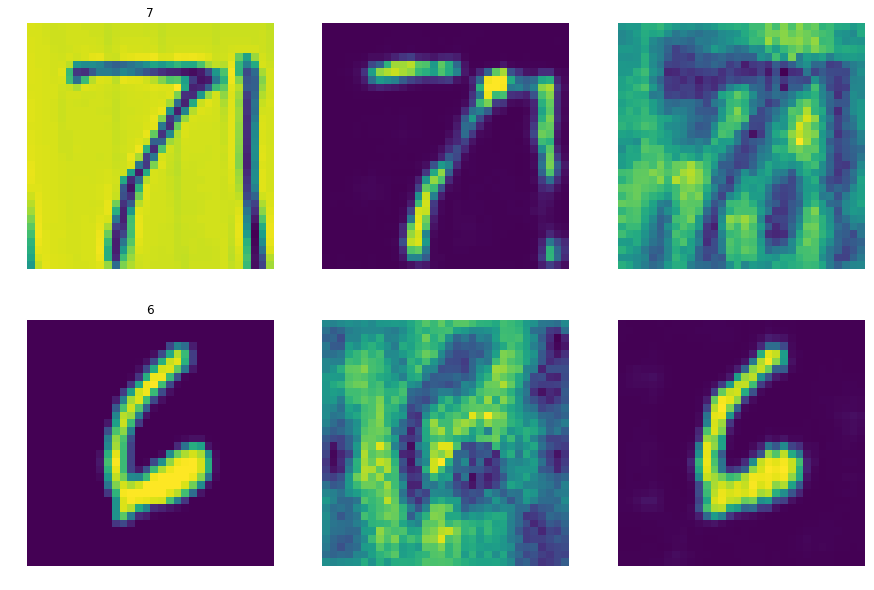

In [45]:
plt.rcParams['figure.figsize'] = (15, 10)
# plt.axes().set_aspect('equal', 'datalim')
#plt.axis([-3,3,-3,3])

index = 3
plt.subplot(2,3,1)
plt.title(Y_source_predict[index])
plt.imshow(X_source[index].reshape(32,32))
plt.axis('off')

plt.subplot(2,3,2)
plt.imshow(X_s2t[index].reshape(32,32))
plt.axis('off')

plt.subplot(2,3,3)
plt.imshow(X_s2s[index].reshape(32,32))
plt.axis('off')

plt.subplot(2,3,4)
plt.title(Y_target_predict[index])
plt.imshow(X_target[index].reshape(32,32))
plt.axis('off')

plt.subplot(2,3,5)
plt.imshow(X_t2s[index].reshape(32,32))
plt.axis('off')

plt.subplot(2,3,6)
#plt.imshow(np.transpose(X_target_trans[index].reshape(3,32,32), (1,2,0)))
plt.imshow(X_t2t[index].reshape(32,32))
plt.axis('off')

### Learning curves

#### GAN losses

IndexError: list index out of range

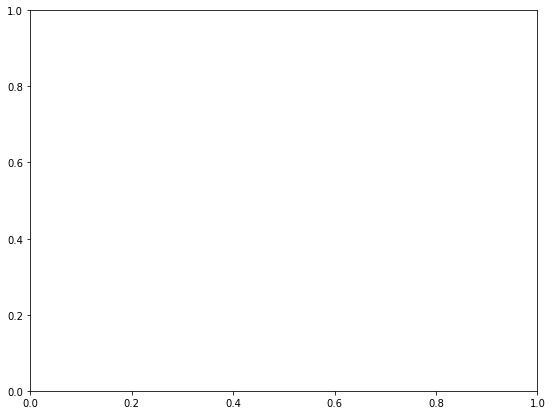

In [45]:
k = 10
start = 0
def smooth(x_list):
    res = [np.sum([x_list[k+j] for j in range(-k, k+1)])]
    for i in range(k+1, len(x_list)-k):
        res.append(res[-1] - x_list[i-k-1] + x_list[i+k])
    return np.array(res) / (2 * k)

plt.rcParams['figure.figsize'] = (20, 7)

plt.subplot(1,2,1)
plt.plot(iter_list[k+start:-k], smooth(D_s2t_loss_list[start:]), label="Discriminator loss − s2t")
plt.plot(iter_list[k+start:-k], smooth(D_t2s_loss_list[start:]), label="Discriminator loss − t2s")
plt.legend()

plt.subplot(1,2,2)
plt.plot(iter_list[k+start:-k], smooth(G_s2t_loss_list[start:]), label="Generator loss − s2t")
plt.plot(iter_list[k+start:-k], smooth(G_t2s_loss_list[start:]), label="Generator loss − t2s")
plt.legend()

#### VAE losses

IndexError: list index out of range

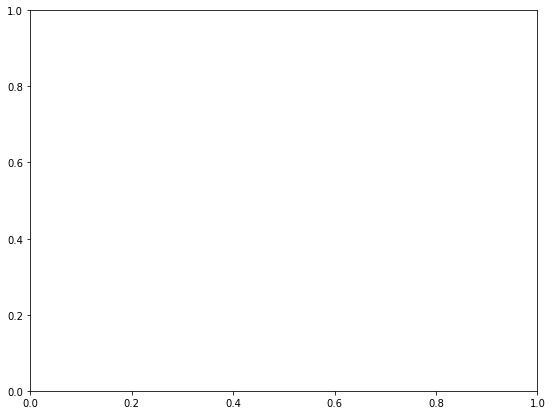

In [44]:
start = 0
k = 10
plt.subplot(1,2,1)
plt.plot(iter_list[k+start:-k], smooth(vae_s2s_loss_list[start:]), label="VAE s2s loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(iter_list[k+start:-k], smooth(vae_t2t_loss_list[start:]), label="VAE t2t loss")
plt.legend()

#### Classification loss

In [45]:
start = 0
k = 10
plt.plot(iter_list[k+start:-k], smooth(classif_t2s_loss_list[start:]), label="Classif loss")
plt.legend()

IndexError: list index out of range

#### Validation accuracy

IndexError: list index out of range

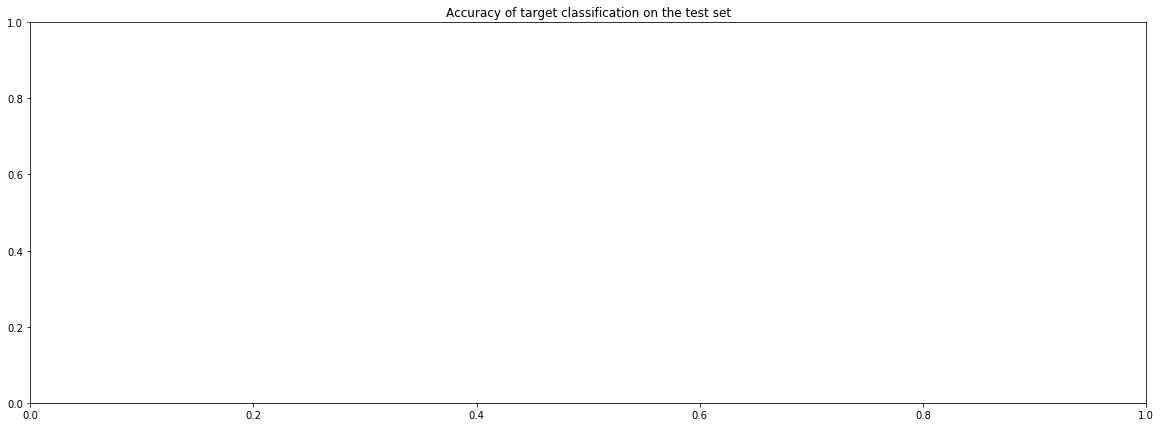

In [46]:
start = 0
k = 100
plt.title("Accuracy of target classification on the test set")
plt.plot(iter_list[k+start:-k], smooth(accuracy_list[start:]), label="Validation accuracy")
plt.legend()

## Test the results

In [60]:
Y_target_predict = np.argmax(sess.run(tf.nn.softmax(DG_t2s_classif), feed_dict={ipt_target: X_target_test[0:1000]}), axis=1)

In [66]:

print(y)
print(Y_target_test)
y=np.argmax(Y_target_test,axis=1)
print(y)

7
[[0 0 0 ..., 1 0 0]
 [0 0 1 ..., 0 0 0]
 [0 1 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]
[7 2 1 ..., 4 5 6]


In [67]:
y1=y[0:1000]
accuracy_score(y1, Y_target_predict)

0.59199999999999997

## Debug

### Gradients

In [ ]:
print("Gradient of D with respect to", ipt_source)
gradient = sess.run(tf.gradients(discriminator(ipt_source, "source")[1], ipt_source), 
                    feed_dict={ipt_source: sample_source})
print("Min:", np.array(np.abs(gradient)).min())
print("Max:", np.array(gradient).max())
print("Avg:", np.array(np.abs(gradient)).mean())

In [ ]:
print("Gradient of D with respect to", ipt_target)
gradient = sess.run(tf.gradients(discriminator(ipt_target, "target")[1], ipt_target), 
                    feed_dict={ipt_target: sample_target})

print("Min:", np.array(gradient).min())
print("Max:", np.array(gradient).max())
print("Avg:", np.array(np.abs(gradient)).mean())

In [ ]:
ind = 1
print("Gradient with respect to", G_s2t_vars[ind])
gradient = sess.run(tf.gradients(G_s2t_loss, G_s2t_vars[ind]), feed_dict={ipt_source: sample_source, 
                                                                          ipt_target: sample_target})
print("Min:", np.array(gradient).min())
print("Max:", np.array(gradient).max())
print("Avg:", np.array(gradient).mean())

In [ ]:
ind = 2
print("Gradient with respect to", G_t2s_vars[ind])
gradient = sess.run(tf.gradients(G_t2s_loss, G_t2s_vars[ind]), feed_dict={ipt_source: sample_source, 
                                                                          ipt_target: sample_target})
print("Min:", np.array(gradient).min())
print("Max:", np.array(gradient).max())
print("Avg:", np.array(gradient).mean())